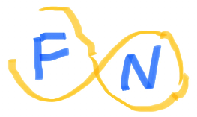



# Welcome to Finite News!
This notebook creates and emails issues of Finite News.

# Parameters for the notebook
The constants below are used for developing and debugging. All other parameters for the newspaper are configured in the files on S3.  
  
<div class="alert alert-block alert-info">
    <p><b>TO DEPLOY A NEW VERSION</b></p>
    <ol>
        <li>Set <code>DEV_MODE</code> & <code>DISABLE_GPT</code> to <code>FALSE</code>.</li>
        <li>Create a new <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/create-notebook-auto-run-studio.html" target="_blank">scheduled notebook job</a> on the Data Science 2.0 image with Python 3.8.</li>
        <li>Delete the old notebook job.</li>
        <li>Shut down the Sagemaker instance if it was used during development.</li>
    </ol>
</div>

In [2]:
DEV_MODE = False # True will not send email and not log newly fetched headlines for dedup later
DISABLE_GPT = False # True will not call GPT API, so we don't incur costs while debugging
LOGGING_LEVEL = "warning" # Logs end up in admin's news email. Use "warning" by default. Change to "info" to get more detailed logs for debugging

# Imports

In [ ]:
!pip install --quiet beautifulsoup4==4.10.0 boto3==1.33.9 botocore==1.33.9 openai==0.27.7 pandas==1.3.4 s3fs==0.4.2 sendgrid==6.10.0

import boto3
from botocore.exceptions import ClientError
from bs4 import BeautifulSoup
from copy import deepcopy
from datetime import date, datetime
from io import StringIO
import json
import logging
import openai
import pandas as pd
import pytz
from random import choice
import requests
import s3fs
fs = s3fs.S3FileSystem()
from sendgrid import Attachment, SendGridAPIClient
from sendgrid.helpers.mail import Mail
from time import sleep
import yaml

# Functions
To play nicely with Sagemaker scheduled notebooks (Papermill), all the code we need lives inside the notebook or is installed by the notebook. Papermill jobs cannot import local Python scripts.

## 📦 Loading
Import data and initialize variables

In [4]:
def init_logging(logging_level):
    """Initialize logging to in-memory object, for optional delivery in admin's issue of Finite News.
    
    NOTE
    Reminder: This function doesn't reset an active log. Must restart the kernel in SageMaker.
    
    ARGUMENTS
    logging_level (str): The granularity of logging messages, 'warning' or 'info'
    
    RETURNS
    log_stream (StringIO object): In-memory file-like object that collects results from logging during the Finite News run
    """
    
    log_stream = StringIO() 
    if logging_level=='warning':
        level = logging.WARNING
    elif logging_level=='info':
        level = logging.INFO
    logging.basicConfig(stream=log_stream, level=level)
    return log_stream


def get_fn_secret(secret_key, secret_name="fn_secrets", region_name="us-east-1"):
    """Retrieve a secret from AWS Secrets Manager.
    
    ARGUMENTS
    secret_key (string): the specific secret to retrieve, such as BUCKET_PATH or OPENAI_API_KEY
    secret_name (string): the group where the Finite News secrets are stored in AWS Secrets Manager
    region_name (string): the region where your AWS Secrets Manager secret_name lives. See the sample code provided by Secrets Manager after you create the secret

    RETURNS
    secret_value (string): the secret!
    """

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e: # Stop the presses, we can't get our secret.
        raise e

    # Decrypt secret using the associated KMS key.
    try:
        return json.loads(get_secret_value_response["SecretString"])[secret_key]
    except KeyError as e:
        raise KeyError(f"Secret key {str(e)} not found. Is it stored in AWS Secrets Manager? Have you given permissions for your SageMaker user to access the secret?") # No sense in logging the exception since we won't be sending any emails (where we store logs)
        

def load_assets_from_s3(bucket_path):
    """Import assets from S3 for the publication in general.

    ARGUMENTS
    bucket_path (str): The location of the S3 bucket where required files are stored.

    RETURNS
    thoughts_of_the_day (list): Jokes and quotes
    substance_rules (dict): Logic for dropping headlines of little substance
    template_html (str): The HTML layout of a Finite News issue
    """

    # List of quotes from which to sample a Thought for the Day
    try:
        with fs.open(bucket_path + "thoughts_of_the_day.yml") as f:
            thoughts_of_the_day = yaml.load(f, Loader=yaml.Loader)["quotes"]
    except Exception as e:
        logging.warning(f"Couldn't load thoughts_of_the_day.yml. load_assets_from_s3() error: {str(type(e))}, {str(e)}")

    # Text rules for filtering out headlines
    try:
        with fs.open(bucket_path + "substance_rules.yml") as substance_rules_file:
            substance_rules = yaml.load(substance_rules_file, Loader=yaml.Loader)
    except Exception as e:
        logging.critical(f"Couldn't load substance_rules.yml. load_assets_from_s3() error: {str(type(e))}, {str(e)}")

    # Template for the email
    try:
        with fs.open(bucket_path + "template.htm", "r") as f:
            template_html = f.read()
    except Exception as e:
        logging.critical(f"Couldn't load template.htm. load_assets_from_s3() error: {str(type(e))}, {str(e)}")
        raise
    
    return thoughts_of_the_day, substance_rules, template_html


def load_publication_config(
    publication_config_file_name="publication_config.yml",
    dev_mode=False,
    disable_gpt=False
):
    """Import general settings and assets from files on S3, used for all subscribers
    
    ARGUMENTS
    publication_config_file_name (str): file name for the general publication parameters YML file in the S3 bucket identified by BUCKET_PATH
    dev_mode (bool): If True we're in development or debug mode, so don't send emails or modify headline_logs.
    disable_gpt (bool): If True, don't call the GPT API and incur costs, for example during dev or debug cycles.
    
    RETURNS
    publication_config (dict): General settings for today's run of Finite News, that apply to all issues / subscribers 
    """
    
    bucket_path = get_fn_secret("BUCKET_PATH")

    # Load publication settings
    with fs.open(bucket_path + publication_config_file_name) as publication_config_file:
        publication_config = yaml.load(publication_config_file, Loader=yaml.Loader)
    
    # Add shared assets
    thoughts_of_the_day, substance_rules, template_html = load_assets_from_s3(bucket_path)
    # Populate config dictionary
    return {
        "bucket_path": bucket_path,
        "email_delivery": not dev_mode, # If dev_mode is True, don't send emails
        "sender": publication_config["sender"],
        "layout": {
            "template_html": template_html,
            "logo_url": publication_config["layout"]["logo_url"],
        },
        "editorial": {
            "one_headline_keywords": publication_config["editorial"]["one_headline_keywords"],
            "substance_rules": substance_rules,
            "log_today_headlines": False if dev_mode else True,
        },
        "nws" : publication_config["nws"],
        "gpt": publication_config.get("gpt", None) if not disable_gpt else None,
        "news_sources": publication_config["news_sources"],
        "arts_sources": publication_config["arts_sources"],
        "thoughts_of_the_day": thoughts_of_the_day,
    }


def get_subscriber_list(bucket_path, folder_name="finite_files"):
    """Find the subscribers (the names of their config files) on the Finite News bucket.
    
    ARGUMENTS
    bucket_path (str): The location of the S3 bucket where required files are stored.
    folder_name (str): The part of the path that contains the folder on the bucket, if present. Used to remove from .
    
    NOTE: 
    1. Assumes the folder is at the root of the bucket. If it's nested, use relative path up to root.
    2. Assumes all files in the folder that begin with "config_" are a subscriber config file.
    
    RETURNS
    subscriber_config_file_names (list): yml file names in finite bucket
    """
    
    fn_bucket = (
        boto3
        .resource("s3")
        .Bucket(
            bucket_path
            .split("//")
            [1]
            .split("/")
            [0]
        )
    )
    # Iterate through files on the bucket and select those that begin with config_
    return [
        f.key.replace(f"{folder_name}/", "")
        for f in fn_bucket.objects.filter(Prefix=f"{folder_name}/")
        if f.key.startswith(f"{folder_name}/config_")
    ]


def personalize_gpt_instruction(instruction, nba_teams=None):
    """Customize the instructions we give GPT for editing headlines, depending on the subscriber's preferences

    ARGUMENTS
    instruction (str): The current GPT instruction text, including the placeholder {NBA_EXCLUSION}
    nba_teams (list): The names of NBA teams the subscriber is tracking
    
    RETURNS
    instruction (str): Updated instruction that tells GPT not to remove those NBA headlines
    """
    
    nba_base = "Don't list a headline if it mentions "
    if len(nba_teams)==1:
        nba_exclusion = nba_base + f"'the {nba_teams[0]}'. "
    elif len(nba_teams)>1:
        nba_exclusion = nba_base + " or ".join([f"'the {team}'" for team in nba_teams]) + ". "
    else: # No NBA teams tracked, so we'll just cut the placeholder {NBA_EXCLUSION} from instruction.
        nba_exclusion = ""
    return instruction.replace("{NBA_EXCLUSION}", nba_exclusion)


def load_subscriber_config(subscriber_config_file_name, publication_config):
    """Import subscriber-specific parameters and combine with general publication settings
    
    ARGUMENTS
    subscriber_config_file_name (str): name of the subscriber's config YML file in the S3 bucket
    publication_config (dict): loaded general publication parameters
    
    RETURNS
    issue (dict): Settings for an issue, combining subscriber and general publication parameters
    """
    
    issue = deepcopy(publication_config) # Copy dict with nested dicts
    with fs.open(issue["bucket_path"] + subscriber_config_file_name) as subscriber_config_file:
        subscriber_config = yaml.load(subscriber_config_file, Loader=yaml.Loader)
    issue["admin"] = subscriber_config.get("admin", False)
    issue["subscriber_email"] = subscriber_config["email"]

    issue["editorial"]["add_car_talk_credit"] = subscriber_config["editorial"].get("add_car_talk_credit", False)
    issue["editorial"]["last_headlines_path"] = ""
    if "editorial" in subscriber_config:
        if "last_headlines_file" in subscriber_config["editorial"]:
            issue["editorial"]["last_headlines_path"] = issue["bucket_path"] + subscriber_config["editorial"]["last_headlines_file"]
    if issue["editorial"]["last_headlines_path"] == "":
        logging.warning("No last_headlines_path. Not logging/updating yesterday's headlines")
    
    issue["arts_sources"] = publication_config["arts_sources"] if subscriber_config["sources"]["add_arts_headlines"] else []
    issue["nba_teams"] = subscriber_config.get("nba_teams", None)
    issue["nws"]["office"] = subscriber_config["nws"]["office"] # Add by element because publication_config has NWS already
    issue["nws"]["grid_x"] = subscriber_config["nws"]["grid_x"]
    issue["nws"]["grid_y"] = subscriber_config["nws"]["grid_y"]
    issue["nws"]["location_name"] = subscriber_config["nws"]["location_name"]
    issue["slogans"] = subscriber_config["slogans"]
    issue["thoughts_of_the_day"] = subscriber_config["thoughts_of_the_day"] + publication_config["thoughts_of_the_day"] if subscriber_config["editorial"].get("add_shared_thoughts", False) else subscriber_config["thoughts_of_the_day"]
    return issue


def load_subscriber_configs(dev_mode, disable_gpt):
    """Create the config file needed to generate each issue, combining publication and subscriber settings.
    
    ARGUMENTS
    dev_mode (bool): If True we're in development or debug mode, so don't send emails or modify headline_logs.
    disable_gpt (bool): If True, don't call the GPT API and incur costs, for example during dev or debug cycles.

    RETURNS
    subscriber_configs (list): issue_config for each subscriber we need to generate an issue for
    """ 
    
    publication_config = load_publication_config(dev_mode=dev_mode, disable_gpt=disable_gpt)    
    subscriber_list = get_subscriber_list(publication_config["bucket_path"])
    subscriber_configs = [
        load_subscriber_config(subscriber_config_file_name, publication_config)
        for subscriber_config_file_name in subscriber_list
    ]
    # Sort subscribers so the "admins" go last. 
    # Allows the admin email issue(s) to include logging warnings from the non-admin issues.
    subscriber_configs = sorted(subscriber_configs , key=lambda x: x["admin"]) 
    return subscriber_configs

## 🕵🏻‍♀️ Reporting
Research the day's news

In [5]:
def scrape_headlines(source):
    """Use a tag scraper to fetch a source's headlines
    
    TODO: Refactor to simplify. Separate if then for get_text vs get_text + split_char.
    
    ARGUMENTS
    source (dict): Description of the website to scrape
    
    RETURNS
    headlines (list of str): Headlines retrieved
    
    """
    response = requests.get(source["url"])
    soup = BeautifulSoup(response.text, "html.parser")
    if "select_query" in source:
        headlines = soup.select(source["select_query"])
        headlines = [headline.contents[0] for headline in headlines]
    elif "tag_class" in source:
        headlines = soup.find_all(source["tag"], {"class":source["tag_class"]})
        if "tag_next" and "split_char" in source:
            headlines = headlines[0].findNext(source["tag_next"]).get_text()
            headlines = [headline for headline in headlines.split(source["split_char"]) if headline]
        else:
            headlines = [headline.contents[0] for headline in headlines]
    else:
        headlines = soup.find_all(source["tag"])
        headlines = [headline.get_text() for headline in headlines]
    if "min_words" in source:
        headlines = [headline for headline in headlines if count_words(headline)>=source["min_words"]] # Have seen some that are just "Advertisement", or author names
    headlines = list(set(headlines)) # De-dup
    return headlines


def call_api_for_headlines(source):
    """Use an API to fetch a source's headlines. 

    NOTE
        - Requires that the API key named in the source config file is stored in AWS Secrets Manager.
        - Assumes API response comes back in JSON format.

    ARGUMENTS
    source (dict): Description of the API to call and parse
    
    RETURNS
    headlines (list of str): Headlines retrieved
        
    """
    response = requests.get(source["url"] + get_fn_secret(source["api_key_name"]))
    results = response.json()["results"]
    headlines = [article[source["headline_field"]] for article in results]
    return headlines


def get_todays_nba_game(team_name):
    """Call the NBA API to find out if a team is playing today.
    
    NOTE
    This updated version accounts for the limitation of using the NBA API's current day's scoreboard: 
    the scoreboard isn't always updated until a certain hour in the morning, after FN may be run.
    The updated approach here looks at the whole year's schedule, including post-season. Adapted from : https://github.com/swar/nba_api/issues/296

    TODO: Clean and simpify. No need to use Pandas.
    
    ARGUMENTS:
    team_name (str): NBA team such as "Celtics" or "Lakers"
    
    RETURNS
    message (str or None): A headline-style update if the team is playing tonight.

    """
    try:
        url = 'https://cdn.nba.com/static/json/staticData/scheduleLeagueV2.json'
        r = requests.get(url)
        schedule = r.json()
        schedule = schedule['leagueSchedule']['gameDates']
        games = []
        for gameday in schedule:
            for game in gameday['games']:
                game_details = [
                        game['gameDateTimeUTC'],
                        game['homeTeam']['teamName'],
                        game['homeTeam']['teamCity'],
                        game['awayTeam']['teamName'],
                        game['awayTeam']['teamCity'],
                       ]
                game_details = pd.DataFrame(
                    [game_details],
                    columns =[
                        "gameDateTimeUTC",
                        "homeTeam",
                        "homeCity",
                        "awayTeam",
                        "awayCity",
                    ]
                )
                games.append(game_details)
        games = pd.concat([game for game in games])

        eastern = pytz.timezone('US/Eastern')
        games['gameDateTimeUTC'] = pd.to_datetime(games['gameDateTimeUTC'], errors='coerce')
        games = games.dropna(subset=['gameDateTimeUTC'])
        games['gameDateTimeEastern'] = games['gameDateTimeUTC'].apply(lambda t: t.astimezone(eastern))
        games['gameDate'] = games['gameDateTimeEastern'].apply(lambda d: d.date())

        game = (
            games.loc[
                ((games['awayTeam'] == team_name) | (games['homeTeam'] == team_name))
                & (games['gameDate'] == datetime.today().date())]
        )
        if game.shape[0]==1:
            game = game.iloc[0]
            tipoff = game["gameDateTimeEastern"].strftime("%I:%M").lstrip("0").replace(":00","")
            if team_name in game["homeTeam"]:
                other_team = game["awayTeam"]
                message = f"The {team_name} host the {other_team} at {tipoff}."
            else:
                other_city = game["homeCity"]
                message = f"The {team_name} are in {other_city}. Tipoff at {tipoff}."
        else:
            message=None
    except Exception as e:
        logging.warning(f"NBA game error for {team_name}: {str(type(e))}, {str(e)}")
        message= None
    return message


def download_headlines(source):
    """Fetch a source's desired content from the Internet.

    ARGUMENTS
    source (dict): Description of the API to call or website to scrape
    
    RETURNS
    headlines (list of str): Headlines retrieved
    """
    
    if source["method"]=="api":
        return call_api_for_headlines(source)
    if source["method"]=="scrape":
        return scrape_headlines(source)
    

def research_headlines(source, max_headlines):
    """Download headlines from a source then post-process each source's list. 

    NOTE
    See also clean_headline() for post-processing that's done on the level of an individual headline.
    
    ARGUMENTS
    source (dict): Description of the API to call or website to scrape
    max_headlines (int): The upper limit on how many headlines we will take from this source
    
    RETURNS
    headlines (list of str): Headlines from the source, after postprocessing
    """
    
    # Get those headlines
    headlines = download_headlines(source)
    
    # Lightly postprocess 'em
    if headlines:
        headlines = [headline.strip() for headline in headlines if headline]
        if max_headlines:
            headlines = headlines[0:max_headlines]
    return headlines
  
    
def research_source(source):
    """Download a source's content then post-process.

    ARGUMENTS
    source (dict): Description of the API to call or website to scrape

    RETURNS
    source (dict): Dictionary with new key "headlines" (list of str)

    """
    if source["type"]=="headlines":
        source["headlines"] = research_headlines(
            source=source, 
            max_headlines=source.get("max_headlines", None)
        )
    if len(source['headlines'])==0 and not source.get("exclude_from_0_results_warning", False): # Escalate to admin if no results were returned, and that was unexpected. Source's scraper/API may be broken.
        logging.warning(f"{source['name']}: retrieved 0 headlines") 
    else:
        logging.info(f"{source['name']}: retrieved {len(source['headlines'])} headlines")
    return source


def research_sources(sources):
    """Get content from multiple sources, through various means, and post-process.
    
    ARGUMENTS
    sources (list of dict): A list of sources to get headlines from
    
    RETURNS
    sources (dict): List of source description dictionaries with new key "headlines" (list of str)
    """
    
    sources = [research_source(source) for source in sources]
    return sources


def get_forecast(nws_config):
    """Use National Weather Service API to get local forecast.
        
    ARGUMENTS
    nws_config (dict): Parameters for calling the NWS API, including keys for:
        - office (str): Which NWS office to get the forecast from (See NOTE above)
        - grid_x (int), grid_y (int): Coordinates for the forecast (See NOTE above)
        - location_name (str): Town or city name (no state/country etc)
        - api_snooze_bar (int): How many seconds to wait before retrying NWS after an exception

    RETURNS
    forecast (dict or None): Attributes of the forecast retrieved, or None if there was a problem.
    """
    
    MAX_ATTEMPTS = 10 
    try:
        attempts=1
        while attempts<MAX_ATTEMPTS:
            url =f"https://api.weather.gov/gridpoints/{nws_config['office']}/{nws_config['grid_x']},{nws_config['grid_y']}/forecast"
            r = requests.get(url, timeout=5)
            if r.status_code==200:
                break
            else:
                attempts+=1
                logging.info(f"Weather request {r.status_code}. Wait {nws_config['api_snooze_bar']} seconds and retry, take # {attempts} ...")
                sleep(10)
        
        result = r.json()["properties"]["periods"][0]
        forecast = {
            "short": result.get("shortForecast", None),
            "detailed": result.get("detailedForecast", None),
            "icon_url": result.get("icon", None)
        }
        forecast["short"] = forecast["short"].capitalize() # Change from Title Case to Sentence case 
        if nws_config["location_name"]:
            forecast["short"] += f" in {nws_config['location_name']}"
        return forecast
    except Exception as e:
        logging.warning(f"Forecast error after {MAX_ATTEMPTS} attempts: {str(type(e))}, {str(e)}, {r}")
        return None
    

def get_weather_emoji(forecast):
    """
    Label a weather forecast with an emoji. It's used to spice up the section header.
    
    ARGUMENTS
    forecast (dict): Attributes of the forecast retrieved.
    
    RETURNS
    emoji (str): One character
    """

    forecast = forecast.lower()
    if "tornado" in forecast:
        return "🌪️"
    if "hurricane" in forecast:
        return "🌀"
    if "thunder" in forecast or "lightning" in forecast:
        return "⚡"
    if "snow" in forecast or "flurries" in forecast:
        return "❄️"
    if "rain" in forecast or "pour" in forecast or "shower" in forecast or "drizzle" in forecast: # Must come after snow for snow showers
        return "☔"
    if "hot" in forecast:
        return "🥵"
    if "freezing" in forecast:
        return "🥶"
    if "partly cloudy" in forecast or "mostly sunny" in forecast:
        return "🌤️"
    if "sunny" in forecast or "beautiful" in forecast or "warm" in forecast: # Must come after mostly sunny
        return "😎"
    if "mostly cloudy" in forecast:
        return "🌥️"
    if "cloudy" in forecast:
        return "☁️"
    if "windy" in forecast:
        return "🌬️"
    return "🔮"


def get_screenshots(sources):
    """Not currently working on SM. Disabled."""
    if not sources:
        return []
    options = Options()
    options.add_argument('headless')
    s=Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=s, options=options)
    driver.maximize_window()

    screenshots = []
    for source in sources:
        url = source["url"]
        driver.get(url)
        try:
            elements = driver.find_elements(By.CLASS_NAME, source["element_class"])
            if source.get("automate_gradually", False):
            # TODO: Temporary workaround for Birdcast. There's surely a better way
                b64_screenshots = [element.screenshot_as_base64 for element in elements]
                screenshot_b64 = b64_screenshots[source["element_number"]]
            else:       
                # The simpler way that should work for nondynamically loaded images
                chart_element = elements[source["element_number"]]
                screenshot_b64 = chart_element.screenshot_as_base64
        except Exception as e:
            logging.warning(f"Selenium error on {source['url']}: {str(type(e))}, {str(e)}")
        screenshots.append(screenshot_b64)
        driver.quit()
    return screenshots


def get_attributions(headline_sources, nba_used, nws_used):
    """Compile the names of all sources used in the issue, to give credit.
    
    ARGUMENTS
    headline_sources (list of dict): A list of sources we tried to get headlines from
    nba_used (bool): True if the issue tracks an NBA team
    nws_used (bool): True if we were got a local forecast
    
    RETURNS
    attributions (list of str): The names of the sources
    """
    
    attributions = list(set([source["name"] for source in headline_sources])) # De-dups
    attributions += ["Car Talk credits"]
    if nba_used: attributions+= ["NBA API"]
    if nws_used: attributions+= ["National Weather Service"]
    attributions = sorted(attributions)
    return ", ".join(attributions)


def get_car_talk_credit(bucket_path):
    """Pull a random Car Talk credit from a CSV on S3. 
    
    NOTE
    - These credits are fake staff credits that were used at the end of each episode of
    the National Public Radio automotive advice radio show, Car Talk
    - They came from downloading https://www.cartalk.com/content/staff-credits.

    ARGUMENTS 
    bucket_path (str): The location of the S3 bucket where required files are stored.

    RETURNS
    car_talk_credit (str): A fake staff member to thank for creation of this issue of Finite News :D
    """
    
    return ": ".join(
        pd.read_csv(bucket_path + "car_talk_credits.csv", header=None)
        .sample(1)
        .values
        .flatten()
        .tolist()
    )

## ✂️ Editorial
Refine the news and other reporting results

In [6]:
def count_words(text):
    """Helper function to count how many words are in a string.
    
    TODO: Use a tokenizer/built-in
    
    ARGUMENTS
    text (str)
    
    RETURNS
    count (int)
    """
    
    return len(text
               .strip()
               .split(" "))


def log_headlines(headlines, last_headlines_path):
    """Export a list of today's headlines, so we can use them to de-dup tomorrow's news.
    
    NOTE: Must call this before edit_research so we carry forward repeats that were dropped too

    ARGUMENTS
    headlines (list of str): Headlines from all sources
    last_headlines_path (str): The full path on S3 for this subscriber's cache of yesterday's headlines

    RETURNS
    None
    """
    
    with fs.open(last_headlines_path, "w") as cache_file:
        for headline in headlines:
            cache_file.write(f"{headline}\n")
        logging.info(f"Wrote last headlines to {last_headlines_path}")
            

def apply_one_headline_keyword_filter(headlines, keyword):
    """Cap headlines mentioning this keyword.

    ARGUMENTS
    headlines (list of str): Headlines from all sources

    RETURNS
    new_headlines (list of str): Headlines except those that contain this keyword
    """
    
    new_headlines = []
    kw_counter = 0
    keyword = keyword.lower()
    for headline in headlines:
        has_kw = keyword in headline.lower() # Could add spaCy tokenizer, split on spaces, punctuation. But the benefit would be teeny. Empirically this has been working perfectly for months.
        kw_counter += has_kw
        if not has_kw or kw_counter<=1:
            new_headlines.append(headline)
    return new_headlines


def limit_one_headline_keywords(headlines, keywords):
    """Apply user's policy to have a maximum of one article with each keyword in a singles issue.
    
    ARGUMENTS
    headlines (list of str): Headlines from all sources
    keywords (list of str): Keywords that should appear in the issue at most one time
    
    RETURNS
    new_headlines (list of str): Headlines except those cut for containing keywords already reported on once

    """
    for keyword in keywords:
        headlines = apply_one_headline_keyword_filter(headlines, keyword)
    return headlines


def remove_repeat_headlines(headlines, last_headlines_path):
    """Don't present a headline if it was already delivered yesterday.
    
    ARGUMENTS
    headlines (list of str): Headlines from all sources
    last_headlines_path (str): The full path on S3 for this subscriber's cache of yesterday's headlines
    
    RETURNS
    fresh_headlines (list of str): Headlines except those we already delivered yesterday
    """
    
    with fs.open(last_headlines_path, "r") as f:
        last_headlines = [line.strip() for line in f.readlines()]
        logging.info(f"Read last headlines from {last_headlines_path}")
    fresh_headlines = [headline for headline in headlines if headline not in last_headlines]
    logging.info(f"Removed repeat headlines: {[headline for headline in headlines if headline in last_headlines]}") 
    return fresh_headlines


def collect_all_headlines(sources):
    """Extract headlines from all sources we researched.
    
    ARGUMENTS
    sources (list of dict): A list of sources and their headlines

    RETURNS
    headlines (list of str): Flat list of headlines retrieved from all sources
    
    """
    headlines_nested = [source["headlines"] for source in sources if "headlines" in source and source["headlines"]]
    return [item for sublist in headlines_nested for item in sublist]


def lower_list(l):
    """Helper function to lowercase the items in a list of strings.
    
    ARGUMENTS
    l (list of str): A list of headlines
    
    RETURNS
    l_lower (list of str): A list of lowercase headlines
    """
    
    if not l:
        return None
    return [item.lower() for item in l]


def breaks_rule(headline, cant_begin_with, cant_contain, cant_end_with):
    """Evaluate whether a headline breaks any of the passed sets of editorial rules
    
    ARGUMENTS
    headline (str): The text to evaluate
    cant_begin_with (list of str): Text that a headline cannot start with
    cant_contain (list of str): Text that cannot exist anywhere in a headline
    cant_end_with (list of str): Text that a headline cannot end with
    
    RETURNS
    True if this headline violates any rule
    """
    
    for phrase in cant_begin_with:
        if headline.startswith(phrase):
            return True
    for phrase in cant_contain:
        if phrase in headline:
            return True
    for phrase in cant_end_with:
        if headline.endswith(phrase):
            return True

        
def apply_substance_rules(headlines, substance_rules):
    """Remove headlines that fail our logic for ensuring a headline is substanative.

    ARGUMENTS
    headlines (list of str): The headlines retrieved from all sources
    substance_rules (dict): The editorial rules, which consist of lists of phrases
    
    RETURNS
    kept_headlines (list of str): The headlines that pass all substrance rules.

    """
    cant_begin_with = lower_list(substance_rules.get("cant_begin_with", []))
    cant_contain = lower_list(substance_rules.get("cant_contain", []))
    cant_end_with = lower_list(substance_rules.get("cant_end_with", []))
    removed_headlines = [headline for headline in headlines if breaks_rule(headline.lower(), cant_begin_with, cant_contain, cant_end_with)]
    logging.info(f"Substance rules removed: {removed_headlines}")
    kept_headlines = [headline for headline in headlines if headline not in removed_headlines]
    return kept_headlines 


def openai_chat_completion(gpt_config, message):
    """Make an API call to the OpenAI GPT chat endpoint.
    
    ARGUMENTS
    gpt_config (dict): Parameters for using the API
    message (str): The full prompt to send GPT, including generic lead-in, headlines, and instruction (customized to each subscriber)
    
    RETURNS
    headlines_to_remove_str (string): GPT's response of which headlines to remove, in str format
    """
    
    response = openai.ChatCompletion.create(
        model=gpt_config["substance_filter_model"],
        messages=[
            {"role":"system", "content": gpt_config["system_role"]},
            {"role": "user", "content": message}
        ]
    )
    return response["choices"][0]["message"]["content"]


def apply_substance_filter_model(headlines, gpt_config, nba_teams=None):
    """Use LLM to remove headlines that don't say much useful.
    
    NOTE
    Requires an OPENAI_API_KEY in AWS Secrets Manager.
    
    ARGUMENTS
    headlines (list): List of string headlines, original candidates for the issue
    gpt_config (dict): Configuration for editing headlines using GPT LLM through the Open AI API.
    nba_teams (list): The names of NBA teams we're tracking, to ensure GPT doesn't cut those headlines. They're important!
    
    RETURNS
    kept_headlines (list): The headlines that GPT did not remove
    """
    
    GPT_RETRY_SLEEP = 30
    openai.api_key = get_fn_secret("OPENAI_API_KEY")
    headlines_for_gpt = [f"* {headline}" for headline in headlines]
    lead_in = "Here are today's news headlines:"
    message = lead_in + "\n" + "\n".join(headlines_for_gpt) + "\n" + gpt_config["instruction"]
    try:
        try:
            headlines_to_remove_str = openai_chat_completion(gpt_config, message)
        except openai.error.APIConnectionError:
            logging.info(f"OpenAI API error. Waiting {GPT_RETRY_SLEEP} secs, retrying...")
            sleep(GPT_RETRY_SLEEP)
            headlines_to_remove_str = openai_chat_completion(gpt_config, message)
            logging.info(f"OpenAI API error. Waiting {GPT_RETRY_SLEEP} secs, retrying...")
            logging.info("Retry worked! 😅")
    except Exception as e:
        logging.warning(f"OpenAI failed: {str(type(e))}, {str(e)}")
        headlines_to_remove_str = None

    headlines_to_remove = [h for h in headlines_to_remove_str.split("\n")]
    removed_headlines = [headline for headline in headlines if headline in headlines_to_remove] # Extra QC step to make sure GPT didn't return a hallucination that wasn't in headlines we sent it.
    logging.info(f"GPT removed: {removed_headlines}") 
    return [headline for headline in headlines if headline not in removed_headlines]


def clean_headline(headline):
    """Standardize text formatting of a headline string
    
    NOTE
    - Assumes we have already stripped white space from beginning and end of headline
    - We apply these steps before applying substance rules, which rely on standard format,
    before checking if these headlines were in yesterday's issue, and before logging today's headlines.

    ARGUMENTS
    headline (str): A single headline.
    
    RETURNS
    headline (str): A single, clean headline.
    """ 
    
    headline = headline.replace("’","'").replace("‘","'") # Standardize apostrophe characters
    # Ensure all have trailing period
    return headline + "." if not headline.endswith(".") and not headline.endswith("?") else headline 


def edit_headlines(raw_headlines, editorial_policies, gpt_config=None):
    """Apply all editorial policies to the headlines.
    
    ARGUMENTS
    raw_headlines (list): List of string headlines, original candidates for the issue
    editorial_policies (dict): Rules and preferences from this user/issue's config
    gpt_config (dict): Configuration for editing headlines using GPT LLM through the Open AI API.
    
    RETURNS
    edited_headlines (list): Headlines after filtering ones that violate editorial policies
    """
    
    edited_headlines = [clean_headline(headline) for headline in raw_headlines]  
    if "one_headline_keywords" in editorial_policies:
        edited_headlines = limit_one_headline_keywords(edited_headlines, editorial_policies["one_headline_keywords"])
    edited_headlines = remove_repeat_headlines(edited_headlines, editorial_policies["last_headlines_path"])
    if edited_headlines:
        edited_headlines = apply_substance_rules(edited_headlines, editorial_policies["substance_rules"])
        if gpt_config:
            edited_headlines = apply_substance_filter_model(edited_headlines, gpt_config)
        else:
            logging.info("Did not apply GPT substance model. no gpt_config")
            pass
    logging.info("Edited headlines: " + str(edited_headlines))
    return edited_headlines


def edit_nba_headlines(nba_headlines, nba_teams):
    """Clean and harmonize NBA game headlines. The key outcome: when two of our tracked teams are playing each other, only report once, not twice.
    
    ARGUMENTS
    nba_headlines (list of str): News related to today's NBA game(s) for tracked teams
    nba_teams (list of str): The names of the tracked teams that may be in the headlines.
    
    RETURNS
    cleaned_headlines (list of str): Harmonized news about today's NBA game(s)
    """
    
    # Avoid [None] lists
    nba_headlines = [h for h in nba_headlines if h] 

    # If two tracked teams are playing each other, only give one headline
    cleaned_headlines = []
    teams_already_reported = set()
    for headline in nba_headlines:
        teams_found = {t for t in nba_teams if t in headline}
        if not teams_already_reported.intersection(teams_found):
            cleaned_headlines.append(headline)
        teams_already_reported.update(teams_found) 
    return cleaned_headlines

## 🎨 Design
Lay out the email

In [7]:
def format_issue(
    issue_config,
    headlines,
    arts_headlines,
    images,
    log_stream
):
    """Organize the final content as HTML for one subscriber's issue.
    
    ARGUMENTS
    issue_config (dict): The settings for the issue
    headlines (list of str): The final news headlines to be reported in this issue
    arts_headlines (list of str): Optional, the final arts headlines to be reported in this issue
    images (list): Optional, images to attach to the image
    log_stream (String IO): Optional, the log report from running Finite News
    
    RETURNS
    html (str): The Finite News template populated with the final content
    """
    
    html = issue_config["layout"]["template_html"]
    html = html.replace("[[LOGO_URL]]", issue_config["layout"]["logo_url"])
    slogans = issue_config.get("slogans", [''])
    html = html.replace("[[SLOGAN]]", choice(slogans))

    headlines_html = [f"<li>{headline}</li>" for headline in headlines]
    headlines_html = "".join(headlines_html)
    if headlines_html:
        headlines_block = f"<ul>{headlines_html}</ul>"
    else:
        headlines_block = "<p>🦗 chirp...chirp... no new headlines since last issue🦗"
    html = html.replace("[[HEADLINES_BLOCK]]", headlines_block)

    if arts_headlines:
        arts_headlines_html = [f"<li>{headline}</li>" for headline in arts_headlines]
        arts_headlines_html = "".join(arts_headlines_html)
        if arts_headlines_html:
            arts_headlines_block = f"<h3>🖼️ The Arts</h3><ul>{arts_headlines_html}</ul>"
        else:
            arts_headlines_block = ""
    else: 
        arts_headlines_block = ""
    html = html.replace("[[ARTS_BLOCK]]", arts_headlines_block)

    forecast=issue_config["nws"].get("forecast", None)
    if forecast:
        weather_emoji = get_weather_emoji(forecast["short"])
        weather_block = f"<h3>{weather_emoji} {forecast['short']}</h3><img src={forecast['icon_url']} alt='Forecast icon'><br><p>{forecast['detailed']}</p>"
    else:
        weather_block = ""
    html = html.replace("[[WEATHER_BLOCK]]", weather_block)

    if images:
        images_block = "".join([f"<img src='cid:image_{i}', alt='image_{i}'><br>" for i in range(0,len(images))])
    else:
        images_block = ""
    html = html.replace("[[IMAGES_BLOCK]]", images_block)
    
    if issue_config["editorial"]["add_car_talk_credit"]:
        car_talk_block = "<p>" + get_car_talk_credit(issue_config["bucket_path"]) + "</p><br>"
    else:
        car_talk_block = ""
    html = html.replace("[[CAR_TALK_CREDIT]]",car_talk_block)

    try:
        thoughts_of_the_day=issue_config.get("thoughts_of_the_day", [''])
        html = html.replace("[[THOUGHT_OF_THE_DAY]]", choice(thoughts_of_the_day))
    except TypeError as e:
        logging.warning(f"TypeError on replace closing thoughts. Yaml malfored?: {e}. thoughts_of_the_day type: {type(thoughts_of_the_day)}. Expected string. {thoughts_of_the_day}")
        html = html.replace("[[THOUGHT_OF_THE_DAY]]","")

    attributions=get_attributions(
        headline_sources=issue_config["news_sources"] + issue_config["arts_sources"],
        nba_used=issue_config["nba_teams"],
        nws_used=issue_config["nws"].get("forecast", None)
    )
    html = html.replace("[[ATTRIBUTIONS]]", attributions)

    if issue_config["admin"]: # Append exceptions from logging to email
        log_items = [l for l in log_stream.getvalue().split("\n") if len(l)>0]
        if log_items:
            log_items_html = "".join([f"<li><i>{log_item}</i></li>" for log_item in log_items])
            logging_block = f"<h3>👾 Logs</h3><ul>{log_items_html}</ul>"
        else:
            logging_block = ""
    else:
        logging_block = ""
    html = html.replace("[[LOGGING_BLOCK]]", logging_block)

    return html

## 📰 Publishing
Orchestrate and deliver the news

In [8]:
def email_issue(sender, subscriber_email, html, images):
    """Send issue of Finite News to a subscriber by email using the SendGrid API service.
    
    NOTE
    Requires a secret in AWS Secret Manager for SENDGRID_API_KEY
    
    ARGUMENTS
    sender (dict): Metadata about the email source, with keys for "subject" and "email"
    subscriber_email (str): The email address for the destination
    html (str): The issue content
    images (list): Optional, png images to attach to the email
    
    RETURNS
    None
    """
    
    brand = sender["subject"]
    today = date.today().strftime("%m.%d.%y").lstrip("0")
    message = Mail(
    from_email=sender["email"],
    to_emails=subscriber_email,
    subject=f"{brand} for {today}",
    html_content=html)
    attachments = []
    for i, image in enumerate(images):
        attachedFile = Attachment(
            disposition='inline',
            file_name=f'image_{i}.png',
            file_type='image/png',
            file_content=image,
            content_id=f'image_{i}',
        )
        attachments.append(attachedFile)
    message.attachment = attachments
    try:
        sendgrid_key = get_fn_secret('SENDGRID_API_KEY')
        sg = SendGridAPIClient(sendgrid_key)
        response = sg.send(message)
        if response.status_code==202:
            logging.info(f"{subscriber_email}: Extry extry! Email is away!")
    except Exception as e:
        logging.critical(f"{subscriber_email}: Error in send_email: {str(type(e))}, {str(e)}") # Admin issue will get this logging line in its email about failures in prior, non-admin issues.

        
def write_issue_to_file(subscriber_name, html):
    """Append issue html to local .txt file of day's issues, creating file if it doesn't exist.
    
    ARGUMENTS
    subscriber_name (str): The name (or email address) of the issue's recipient, to categorize a day's issues
    html (str): The content of the issue
    
    RETURNS
    None
    
    """
    with open(f"issues_for_{datetime.now().strftime('%m-%d-%y')}.txt", "a") as f:
        f.write(f"""{subscriber_name}\n{datetime.now().strftime('%m-%d-%y %H:%M:%S')}\n{html}\n--------------------------------------------\n""")
    logging.info(f"{subscriber_name}: Extry extry! Wrote to text file.")


def deliver_issue(issue_config, html, images):
    """Send the content of Finite News to one subscriber by the selected method

    ARGUMENTS
    issue_config (dict): The settings for the issue
    html (str): The content of the email formatted for the email
    images (list): Optional, images to attach to the image
    
    RETURNS
    None
    """
    logging.info(f"{issue_config['subscriber_email']}: Starting deliver_issue()")
    if issue_config["email_delivery"]:
        email_issue(issue_config["sender"], issue_config["subscriber_email"], html, images)
    else: 
        write_issue_to_file(subscriber_name=issue_config["subscriber_email"], html=html)


def create_issue(issue_config, log_stream):   
    """Populate the content of Finite News customized for one subscriber
    
    ARGUMENTS
    issue_config (dict): The settings for the issue
    log_stream (StringIO object): In-memory file-like object that collects results from logging during the Finite News run
    
    RETURNS
    html (str): The content of the email formatted for the email
    images (list): Optional, images to attach to the image
    """    
    
    logging.info(f"{issue_config['subscriber_email']}: Starting create_issue()")
    
    # Get tonight's NBA games for tracked teams
    if issue_config["nba_teams"]:
        nba_headlines = [get_todays_nba_game(nba_team) for nba_team in issue_config["nba_teams"]]
        nba_headlines = edit_nba_headlines(nba_headlines, issue_config["nba_teams"])
    else:
        nba_headlines = []

    # Get News headlines
    news_sources = research_sources([source for source in issue_config["news_sources"]])
    news_headlines = nba_headlines + collect_all_headlines(news_sources)
    original_headlines = news_headlines # Before removing repeats or applying substance filters (some are nondeterministic)
    news_headlines = edit_headlines(
        raw_headlines=news_headlines,
        editorial_policies=issue_config["editorial"],
        gpt_config = issue_config["gpt"]
    )
    
    # Get Arts News, if requested
    if len(issue_config["arts_sources"])>0:
        arts_sources = research_sources([source for source in issue_config["arts_sources"]])
        arts_headlines = collect_all_headlines(arts_sources)
        original_headlines += arts_headlines 
        arts_headlines = edit_headlines(
            raw_headlines=arts_headlines,
            editorial_policies=issue_config["editorial"],
            gpt_config = issue_config["gpt"]
        )
    else:
        arts_headlines = []

    if issue_config["editorial"]["log_today_headlines"]==True: 
        log_headlines(original_headlines, issue_config["editorial"]["last_headlines_path"])
    if "nws" in issue_config:
        issue_config["nws"]["forecast"] = get_forecast(issue_config["nws"])
    images = get_screenshots([source for source in news_sources if source["type"]=="screenshot"])
    html = format_issue(issue_config, news_headlines, arts_headlines, images, log_stream)
    logging.info(f"{issue_config['subscriber_email']}: Finished create_issue()")
    return html, images


def run_finite_news(dev_mode, disable_gpt, logging_level=logging.WARNING):
    """Entry point to create and deliver all of today's issues of Finite News.

    ARGUMENTS
    dev_mode (bool): If True we're in development or debug mode, so don't send emails or modify headline_logs.
    disable_gpt (bool): If True, don't call the GPT API and incur costs, for example during dev or debug cycles.
    logging_level (level from logging library): The deepest granularity of log messages to track
    
    RETURNS
    None
    """
    
    log_stream = init_logging(logging_level)
    for subscriber_config in load_subscriber_configs(dev_mode, disable_gpt):
        try:
            html, images = create_issue(subscriber_config, log_stream)
            deliver_issue(subscriber_config, html, images)
        except Exception as e:
            logging.critical(f"{subscriber_config['subscriber_email']}: Issue failed due to unhandled exception: {str(type(e))}, {str(e)}")
    print("👍")

# Run

In [10]:
run_finite_news(DEV_MODE, DISABLE_GPT, LOGGING_LEVEL)

👍
